# Robótica Móvel - Trabalho Prático 1 (Exercícios 1-4)
---
**Nome Completo:** Daniel Terra Gomes

**Matrícula:** 2025702870 

**Programa:** Mestrando do PPGCC  
**Departamento:** Departamento de Ciência da Computação  
**Instituição:** ICEx-UFMG  
**E-mail:** danielterragomes@ufmg.br

**Data:** 11 de setembro de 2025

---

Este notebook implementa os exercícios 1-4 do TP1, focando em:
- Criação de cenas no CoppeliaSim
- Sistemas de coordenadas e transformações
- Matrizes de transformação homogêneas
- Análise de poses relativas entre objetos

## Configuração Inicial e Importações

In [2]:
# Imports necessários
import numpy as np

# Import das utils criadas para o TP1
from robotics_utils import (
    CoppeliaSimConnector,
    SceneAnalyzer,
    wait_for_user_input,
    validate_transformation_matrix
)

# === Configuration and Constants ===

# Default object mapping for TP1 scenes
DEFAULT_OBJECT_MAPPING_EX1_4 = {
    'Robot': 'RobotnikSummitXL',
    'Bill_0': 'Bill[0]',
    'Bill_1': 'Bill[1]',
    'Crate': 'Floor/ConcretBlock',
    'Pillar_0': 'Floor/20cmHighPillar10cm[0]',
    'Pillar_1': 'Floor/20cmHighPillar10cm[1]',
    'Table': 'diningTable',
    'Laptop_0': 'diningTable/laptop[0]',
    'Laptop_1': 'diningTable/laptop[1]',
    'Fence_0': 'Floor/20cmHighWall100cm[0]',
    'Fence_1': 'Floor/20cmHighWall100cm[1]'
}

print("Certifique-se de que o CoppeliaSim está rodando com a cena T1.ttt aberta.")

Certifique-se de que o CoppeliaSim está rodando com a cena T1.ttt aberta.


## Exercício 1: Criação da Cena no CoppeliaSim

O primeiro passo foi criar uma cena no CoppeliaSim contendo um robô móvel (RobotnikSummitXL) e cinco outros objetos distintos para popular o ambiente de simulação.

**Objetos adicionados:**
- 1 Robô móvel: RobotnikSummitXL
- 2 Pessoas: Bill[0] e Bill[1]
- 1 Caixa: Floor/ConcretBlock
- 2 Pilares: Floor/20cmHighPillar10cm[0] e [1]
- 1 Mesa: diningTable
- 2 Laptops: diningTable/laptop[0] e [1]
- 2 Cercas: Floor/20cmHighWall100cm[0] e [1]

A cena foi salva como `T1.ttt` e deve estar carregada no CoppeliaSim para executar este notebook.

## Exercício 2: Diagrama de Transformações

O diagrama a seguir representa as relações entre os sistemas de coordenadas dos objetos na cena. O frame do Mundo {W} serve como referência global.

![Transformation Diagram](ex2-diagram.drawio.png)

*Figura: Diagrama de transformações mostrando os sistemas de coordenadas e as relações entre os diferentes frames na cena. As setas verdes representam transformações conhecidas, enquanto a seta vermelha mostra uma transformação desejada.*

**Conceitos importantes:**
- Cada objeto possui seu próprio sistema de coordenadas local
- O sistema mundial {W} é a referência global
- As transformações podem ser compostas para relacionar qualquer par de frames
- Utilizamos matrizes homogêneas 4x4 para representar posição e orientação

## Conexão com CoppeliaSim e Descoberta de Objetos

In [3]:
# Conectar ao CoppeliaSim
print("Conectando ao CoppeliaSim...")
connector = CoppeliaSimConnector()

if not connector.connect():
    raise RuntimeError("Falha na conexão com CoppeliaSim. Verifique se o simulador está rodando.")

# Descobrir objetos na cena
object_handles = connector.discover_objects(DEFAULT_OBJECT_MAPPING_EX1_4)

if not object_handles:
    raise RuntimeError("Nenhum objeto encontrado. Verifique se a cena T1.ttt está carregada.")

print(f"\nObjetos descobertos: {list(object_handles.keys())}")

Conectando ao CoppeliaSim...
Successfully connected to CoppeliaSim
Discovered 11 objects:
  Robot: Handle 89
  Bill_0: Handle 56
  Bill_1: Handle 130
  Crate: Handle 25
  Pillar_0: Handle 29
  Pillar_1: Handle 49
  Table: Handle 118
  Laptop_0: Handle 122
  Laptop_1: Handle 126
  Fence_0: Handle 17
  Fence_1: Handle 21

Objetos descobertos: ['Robot', 'Bill_0', 'Bill_1', 'Crate', 'Pillar_0', 'Pillar_1', 'Table', 'Laptop_0', 'Laptop_1', 'Fence_0', 'Fence_1']
Discovered 11 objects:
  Robot: Handle 89
  Bill_0: Handle 56
  Bill_1: Handle 130
  Crate: Handle 25
  Pillar_0: Handle 29
  Pillar_1: Handle 49
  Table: Handle 118
  Laptop_0: Handle 122
  Laptop_1: Handle 126
  Fence_0: Handle 17
  Fence_1: Handle 21

Objetos descobertos: ['Robot', 'Bill_0', 'Bill_1', 'Crate', 'Pillar_0', 'Pillar_1', 'Table', 'Laptop_0', 'Laptop_1', 'Fence_0', 'Fence_1']


## Exercício 3: Matrizes de Transformação Homogêneas

Neste exercício, calculamos as matrizes de transformação homogêneas que representam as posições de todos os elementos da cena no referencial local do robô.

**Fundamentação teórica:**
- Matriz homogênea: $T = \begin{bmatrix} R & t \\ 0 & 1 \end{bmatrix}$
- $R$: matriz de rotação 3x3
- $t$: vetor de translação 3x1
- Transformação inversa: $T^{-1} = \begin{bmatrix} R^T & -R^T t \\ 0 & 1 \end{bmatrix}$

In [4]:
# Verificar pose inicial do robô
robot_pose = connector.get_object_pose('Robot')

if robot_pose:
    position, orientation = robot_pose
    print("Pose inicial do robô:")
    print(f"Posição (x, y, z): [{position[0]:.3f}, {position[1]:.3f}, {position[2]:.3f}] metros")
    print(f"Orientação (rx, ry, rz): [{orientation[0]:.3f}, {orientation[1]:.3f}, {orientation[2]:.3f}] radianos")

    # Converter para graus para melhor visualização
    orientation_deg = np.rad2deg(orientation)
    print(f"Orientação (rx, ry, rz): [{orientation_deg[0]:.1f}°, {orientation_deg[1]:.1f}°, {orientation_deg[2]:.1f}°]")
else:
    print("Erro: Não foi possível obter a pose do robô")

Pose inicial do robô:
Posição (x, y, z): [0.000, 1.000, 0.309] metros
Orientação (rx, ry, rz): [0.001, -0.000, 1.571] radianos
Orientação (rx, ry, rz): [0.1°, -0.0°, 90.0°]


### Cenário Inicial: Posição Inicial

![Posição Init](Screenshot-inicial.png)

*Figura: mostrando a posição mencionada*


=== Análise de Transformações - Exercício 3: Pose Inicial ===

Transformações calculadas para 10 objetos:

Bill_0:
  Posição no frame do robô: [0.800, -0.175, -0.309] m
  Matriz válida: ✓

Bill_1:
  Posição no frame do robô: [0.875, -2.200, -0.306] m
  Matriz válida: ✓

Crate:
  Posição no frame do robô: [1.025, 2.000, 0.188] m
  Matriz válida: ✓

Pillar_0:
  Posição no frame do robô: [-2.175, -0.176, -0.209] m
  Matriz válida: ✓

Pillar_1:
  Posição no frame do robô: [-0.375, -0.950, -0.208] m
  Matriz válida: ✓

Table:
  Posição no frame do robô: [0.950, -1.125, 0.068] m
  Matriz válida: ✓

Laptop_0:
  Posição no frame do robô: [0.901, -0.874, 0.520] m
  Matriz válida: ✓

Laptop_1:
  Posição no frame do robô: [0.950, -1.599, 0.521] m
  Matriz válida: ✓

Fence_0:
  Posição no frame do robô: [-2.950, 1.524, -0.211] m
  Matriz válida: ✓

Fence_1:
  Posição no frame do robô: [-2.000, 1.524, -0.211] m
  Matriz válida: ✓


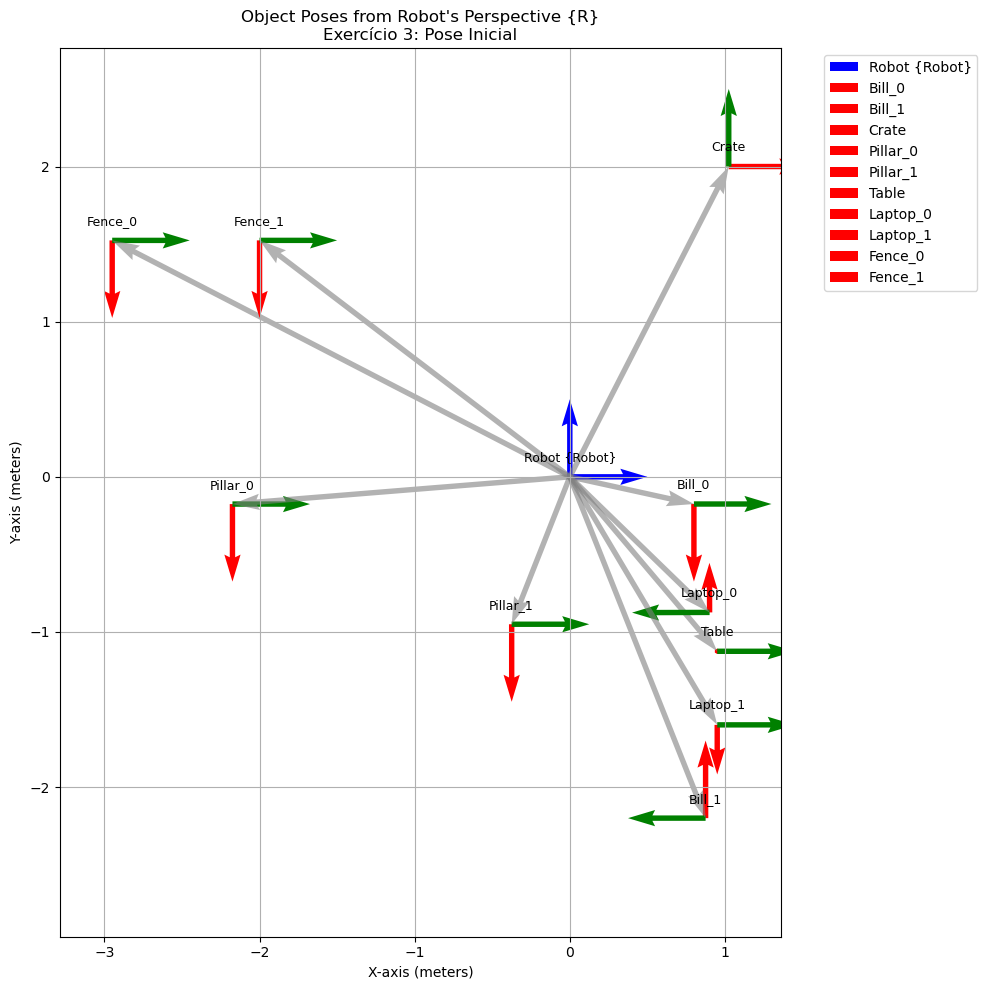

In [5]:
# Função para calcular e exibir transformações
def analyze_scene_transformations(connector, object_handles, scenario_name="Pose Inicial"):
    """
    Analisa e exibe as transformações entre objetos na cena.
    """
    print(f"\n=== Análise de Transformações - {scenario_name} ===")

    # Criar analisador de cena
    analyzer = SceneAnalyzer(connector)

    # Obter lista de objetos (excluindo o robô)
    object_names = [name for name in object_handles.keys() if name != 'Robot']

    # Calcular poses relativas
    relative_poses = analyzer.calculate_relative_poses('Robot', object_names)

    print(f"\nTransformações calculadas para {len(relative_poses)} objetos:")

    for obj_name, T_R_O in relative_poses.items():
        # Extrair posição e orientação no frame do robô
        pos_R = T_R_O[:3, 3]

        print(f"\n{obj_name}:")
        print(f"  Posição no frame do robô: [{pos_R[0]:.3f}, {pos_R[1]:.3f}, {pos_R[2]:.3f}] m")

        # Validar matriz de transformação
        is_valid = validate_transformation_matrix(T_R_O)
        print(f"  Matriz válida: {'✓' if is_valid else '✗'}")

    # Gerar plot
    analyzer.plot_scene_from_robot_perspective('Robot', object_names, scenario_name)

    return relative_poses

# Análise inicial
initial_poses = analyze_scene_transformations(connector, object_handles, "Exercício 3: Pose Inicial")

## Exercício 4: Múltiplas Posições do Robô

Neste exercício, colocamos o robô em três posições diferentes da cena e geramos os respectivos plots, verificando que a implementação funciona para diferentes casos. Variamos também a orientação do robô (frente, lado, costas) em relação aos elementos.

**Instruções:**
1. Mova o robô para diferentes posições na cena usando o CoppeliaSim
2. Execute as células abaixo após cada mudança de posição
3. Observe como as transformações se atualizam automaticamente

### Cenário A: Posição 0 0

![Posição A](Screenshota.png)

*Figura: mostrando a posição mencionada*


CENÁRIO A: x0 y1
Mova o robô para uma posição lateral na cena e execute esta célula.

=== Análise de Transformações - Cenário A: 0 1 ===

Transformações calculadas para 10 objetos:

Bill_0:
  Posição no frame do robô: [0.800, -0.175, -0.309] m
  Matriz válida: ✓

Bill_1:
  Posição no frame do robô: [0.875, -2.200, -0.306] m
  Matriz válida: ✓

Crate:
  Posição no frame do robô: [1.025, 2.000, 0.188] m
  Matriz válida: ✓

Pillar_0:
  Posição no frame do robô: [-2.175, -0.176, -0.209] m
  Matriz válida: ✓

Pillar_1:
  Posição no frame do robô: [-0.375, -0.950, -0.208] m
  Matriz válida: ✓

Table:
  Posição no frame do robô: [0.950, -1.125, 0.068] m
  Matriz válida: ✓

Laptop_0:
  Posição no frame do robô: [0.901, -0.874, 0.520] m
  Matriz válida: ✓

Laptop_1:
  Posição no frame do robô: [0.950, -1.599, 0.521] m
  Matriz válida: ✓

Fence_0:
  Posição no frame do robô: [-2.950, 1.524, -0.211] m
  Matriz válida: ✓

Fence_1:
  Posição no frame do robô: [-2.000, 1.524, -0.211] m
  Matriz vál

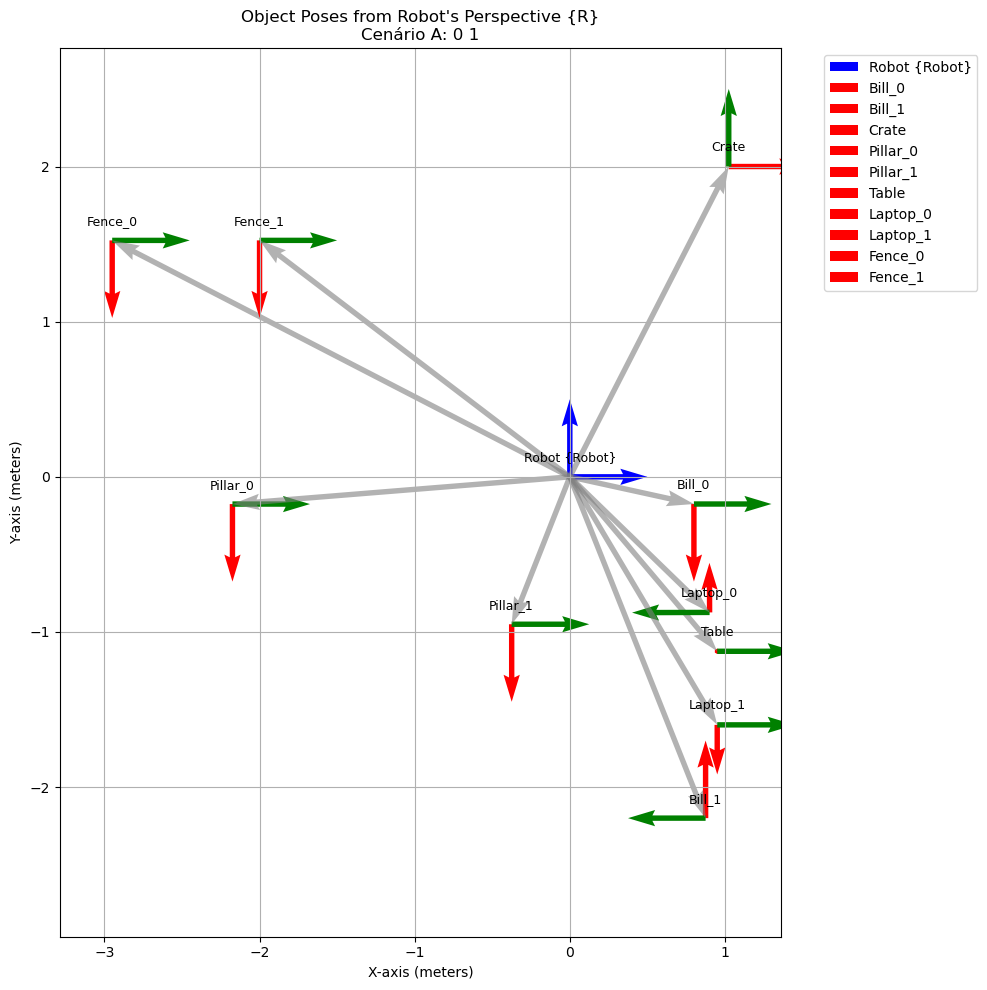

In [ ]:
print("\n" + "="*60)
print("CENÁRIO A: x0 y0")
print("Mova o robô para uma posição lateral na cena e execute esta célula.")
print("="*60)


wait_for_user_input("Pressione Enter após mover o robô para a x0 y0...")

# Análise do cenário A
scenario_a_poses = analyze_scene_transformations(connector, object_handles, "Cenário A: 0 0")

### Cenário B: Posição ao lado do Bill_1

![Posição B](Screenshotb.png)

*Figura: mostrando a posição mencionada*


CENÁRIO B: POSIÇÃO AO LADO DO BILL_1
Mova o robô para ficar de lado aos objetos principais e execute esta célula.

=== Análise de Transformações - Cenário B: Posição de lado para bill_1 ===

Transformações calculadas para 10 objetos:

Bill_0:
  Posição no frame do robô: [-1.974, -0.827, 0.238] m
  Matriz válida: ✓

Bill_1:
  Posição no frame do robô: [0.051, -0.899, 0.231] m
  Matriz válida: ✓

Crate:
  Posição no frame do robô: [-4.149, -1.010, -0.280] m
  Matriz válida: ✓

Pillar_0:
  Posição no frame do robô: [-1.978, 2.146, 0.398] m
  Matriz válida: ✓

Pillar_1:
  Posição no frame do robô: [-1.201, 0.354, 0.241] m
  Matriz válida: ✓

Table:
  Posição no frame do robô: [-1.024, -0.942, -0.149] m
  Matriz válida: ✓

Laptop_0:
  Posição no frame do robô: [-1.274, -0.854, -0.595] m
  Matriz válida: ✓

Laptop_1:
  Posição no frame do robô: [-0.549, -0.902, -0.600] m
  Matriz válida: ✓

Fence_0:
  Posição no frame do robô: [-3.679, 2.915, 0.465] m
  Matriz válida: ✓

Fence_1:
  Posição 

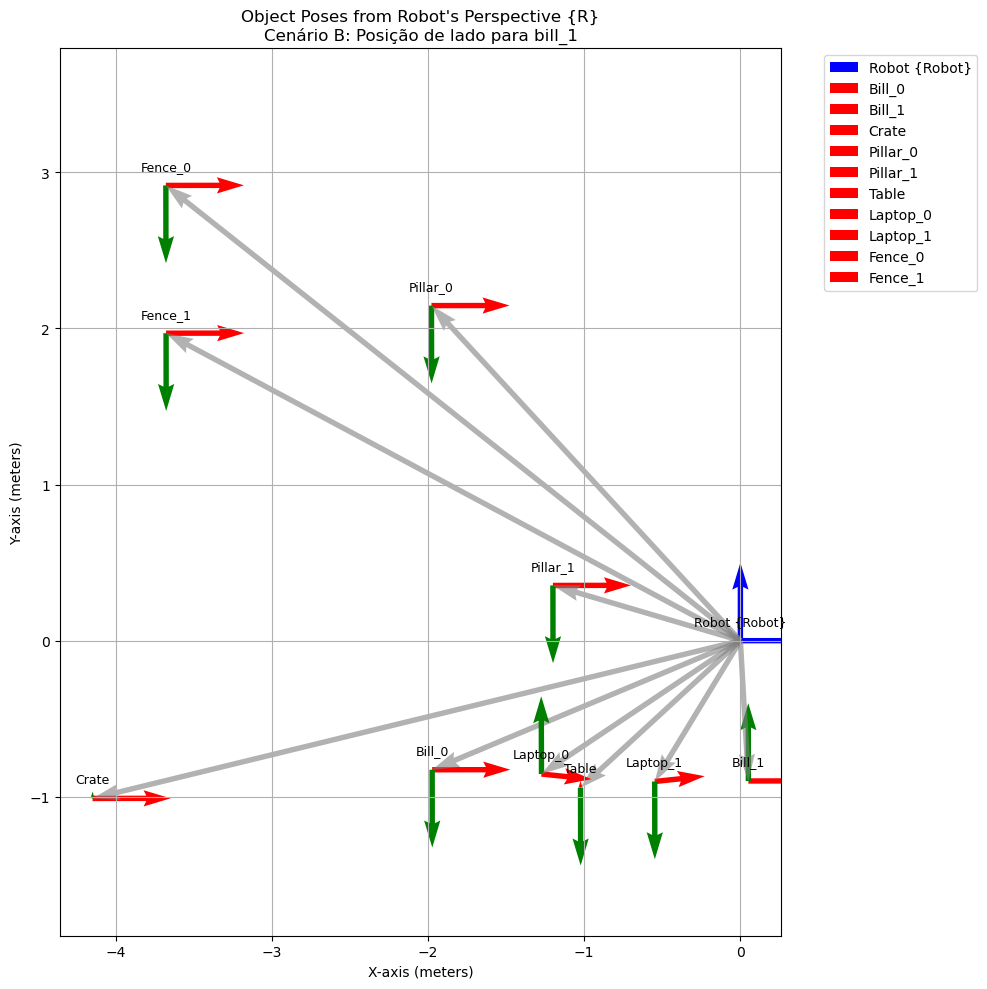

In [6]:
print("\n" + "="*60)
print("CENÁRIO B: POSIÇÃO AO LADO DO BILL_1")
print("Mova o robô para ficar de lado aos objetos principais e execute esta célula.")
print("="*60)

wait_for_user_input("Pressione Enter após mover o robô para a posição de lado para bill_1)...")

# Análise do cenário B
scenario_b_poses = analyze_scene_transformations(connector, object_handles, "Cenário B: Posição de lado para bill_1")

### Cenário C: Posição Traseira para o Crate

![Posição C](Screenshotc.png)

*Figura: mostrando a posição mencionada*



CENÁRIO C: POSIÇÃO TRASEIRA CRATE
Mova e rotacione o robô conforme indicado na imagem e execute esta célula.

=== Análise de Transformações - Cenário C: Posição Traseira para Crate) ===

Transformações calculadas para 10 objetos:

Bill_0:
  Posição no frame do robô: [1.125, 0.043, -0.430] m
  Matriz válida: ✓

Bill_1:
  Posição no frame do robô: [3.150, 0.089, -0.374] m
  Matriz válida: ✓

Crate:
  Posição no frame do robô: [-1.050, -0.194, 0.066] m
  Matriz válida: ✓

Pillar_0:
  Posição no frame do robô: [1.120, -1.946, -2.645] m
  Matriz válida: ✓

Pillar_1:
  Posição no frame do robô: [1.898, -0.790, -1.266] m
  Matriz válida: ✓

Table:
  Posição no frame do robô: [2.075, -0.149, -0.075] m
  Matriz válida: ✓

Laptop_0:
  Posição no frame do robô: [1.825, -0.527, 0.179] m
  Matriz válida: ✓

Laptop_1:
  Posição no frame do robô: [2.550, -0.496, 0.215] m
  Matriz válida: ✓

Fence_0:
  Posição no frame do robô: [-0.581, -2.442, -3.237] m
  Matriz válida: ✓

Fence_1:
  Posição no fram

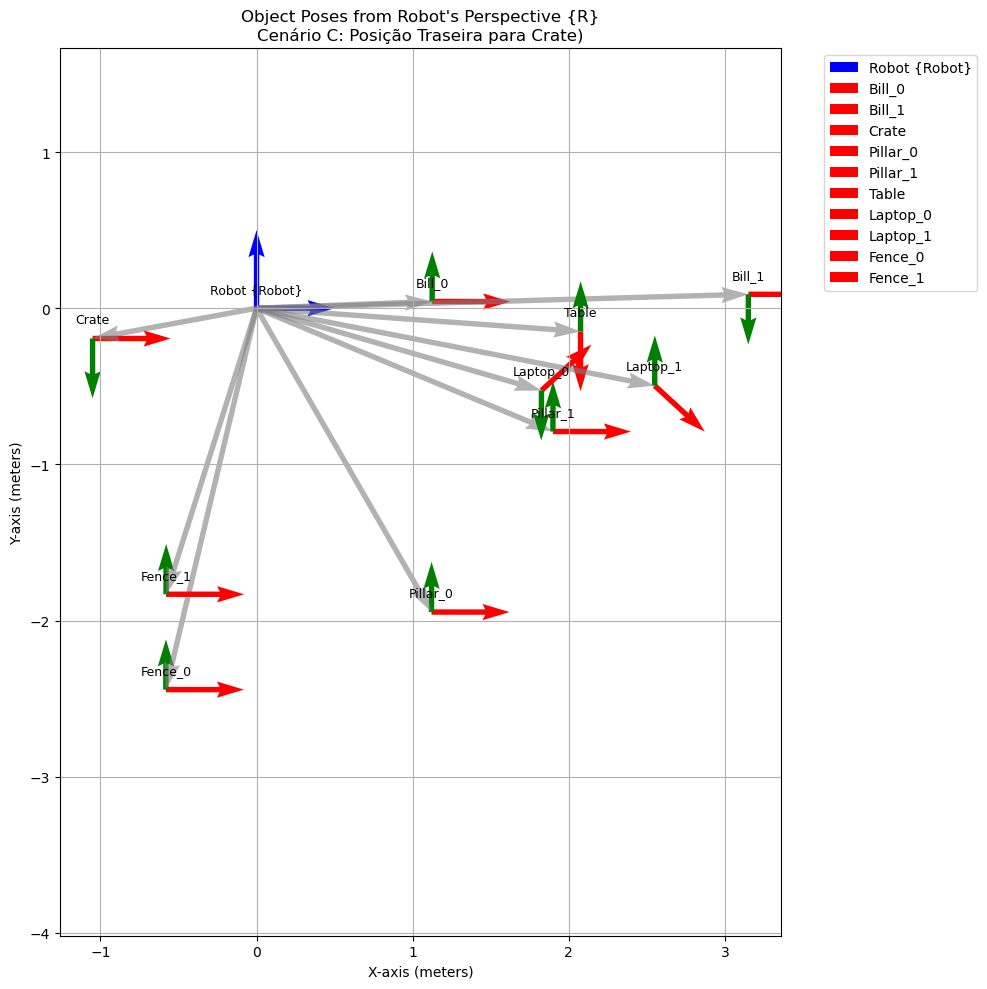

In [7]:
print("\n" + "="*60)
print("CENÁRIO C: POSIÇÃO TRASEIRA CRATE")
print("Mova e rotacione o robô conforme indicado na imagem e execute esta célula.")
print("="*60)

wait_for_user_input("Pressione Enter após mover o robô para a posição com a traseira para Crate)...")

# Análise do cenário C
scenario_c_poses = analyze_scene_transformations(connector, object_handles, "Cenário C: Posição Traseira para Crate)")